# 1. American Sign Language (ASL)¶

American Sign Language (ASL) is the primary language used by many deaf individuals in North America, and it is also used by hard-of-hearing and hearing individuals. The language is as rich as spoken languages and employs signs made with the hand, along with facial gestures and bodily postures.

<img src="https://upload.wikimedia.org/wikipedia/commons/7/7d/American_Sign_Language_ASL.svg" alt='"ASL" spelled out in American Sign Language fingerspelling' style="width: 600px;"/>

A lot of recent progress has been made towards developing computer vision systems that translate sign language to spoken language. This technology often relies on complex neural network architectures that can detect subtle patterns in streaming video. However, as a first step, towards understanding how to build a translation system, we can reduce the size of the problem by translating individual letters, instead of sentences.

In this notebook, I will train a convolutional neural network to classify images of American Sign Language (ASL) letters. After loading, examining, and preprocessing the data, I will train the network and test its performance.

In the code cell below, I load the necessary libraries, and training and test data directories.

In [21]:
import numpy as np
np.random.seed(5) 
import tensorflow as tf
tf.set_random_seed(2)
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

train_dir = "../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
eval_dir = "../input/asl-alphabet-test/asl-alphabet-test"

# 2. Loading the data

Since the data is held in multiple folders in the directories, it is necessary to extract it and store it in arrays. Since I will be doing this operation twice - once on the training data, and again on the evaluation data, it makes sense to write a function that helps with this exaction. This is the function given below, which takes each individual image, resizes it to a convenient size and adds it to an array. It also adds the corresponding `label code` to a `labels` array. A `label code` is simply a number that we associate with each label. For example, `A` goes to `0`, `B`:`1`, `C`:`2` and so on. This is known as label encoding and I will cover it in a little more detail in section 4.

In [2]:
#Helper function to load images from given directories
def load_images(directory):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        for file in os.listdir(directory + "/" + label):
            filepath = directory + "/" + label + "/" + file
            image = cv2.resize(cv2.imread(filepath), (64, 64))
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

Now that we have our helper function, we are ready to use it to extract data. This exaction takes a long time due to the large dataset. Even though I am using GPU services here, it does not help the time as these functions are not able to take advantage of the GPU.

An alternate method for dealing with such large datasets is to use generators - for the images, and the model. Generators are much faster than this manual, almost brute-force method, but they do not allow a similar easy access to the data. Which method to use is a judgement call made on the basis of time and space constraints. Since I have no such meaningful constraints here, I have used the longer method.

In [3]:
import keras

uniq_labels = sorted(os.listdir(train_dir))
images, labels = load_images(directory = train_dir)

if uniq_labels == sorted(os.listdir(eval_dir)):
    X_eval, y_eval = load_images(directory = eval_dir)

Using TensorFlow backend.


Once I have loaded the data, it is time to begin an understanding of it. The code below gives us some basic details about the data.

**Note**: In the train-test split I have used the `stratify` argument on the labels. This argument ensures that the data is split evenly along all labels i.e. the proportion of each label in the testing data is the same as the proportion of the testing data itself - 10%.

Notice that I have two sets of testing images here. This is because the first test set is taken from the same data as the training set - that is, they have a similar look, while the evaluation data, taken from a separate library, has a completely different look. This is done so that I can test the model on both types of data and see how robust it is in the presence of changing backgrounds and colours. The differences between the two testing data will become clear when we look at their images.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1, stratify = labels)

n = len(uniq_labels)
train_n = len(X_train)
test_n = len(X_test)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

eval_n = len(X_eval)
print("Number of evaluation images: ", eval_n)

Total number of symbols:  29
Number of training images:  78300
Number of testing images:  8700
Number of evaluation images:  870


We see that we have a total of 29 symbols. These are the letters A to Z, and symbols for delete, space and nothing. Our total images from the first dataset, 87000 in number, have been split into training images - 78300, and testing images - 8700. We also have an additional 870 evaluation images from a different directory.

# 3. Printing images

We are now ready to print the images for the symbols. I will print one image for each symbol, from each dataset - train, test and evaluation. Since the same operation of printing images is done thrice, I will now write a helper function for this purpose. This function will create a grid of 8x4 images and fill 29 images in the first 29 of the 32 spaces.

In [5]:
#Helper function to print images
def print_images(image_list):
    n = int(len(image_list) / len(uniq_labels))
    cols = 8
    rows = 4
    fig = plt.figure(figsize = (24, 12))

    for i in range(len(uniq_labels)):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(image_list[int(n*i)])
        plt.title(uniq_labels[i])
        ax.title.set_fontsize(20)
        ax.axis('off')
    plt.show()

With our helper function now ready, we begin to print the images. The code lines above the print command: 

`y_train_in = y_train.argsort()
y_train = y_train[y_train_in]
X_train = X_train[y_train_in]` 

sort the data according to the symbols, making it easier for us to deal with it, and ensures that we do not run into any mismatches of data image and its symbol.

Training Images: 


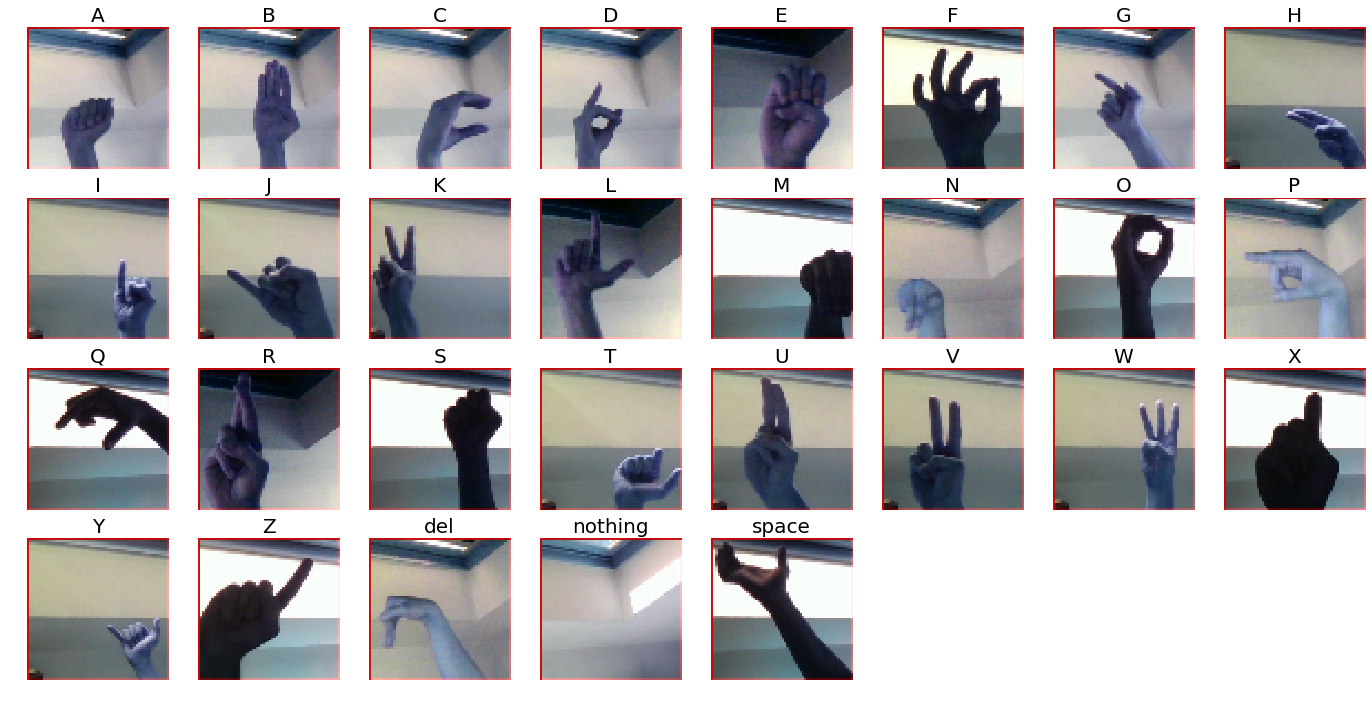

In [6]:
y_train_in = y_train.argsort()
y_train = y_train[y_train_in]
X_train = X_train[y_train_in]

print("Training Images: ")
print_images(image_list = X_train)

Notice how the training images are all in a similar environment, with a combination of lights and shadows. We will address these issues later.

Let us now print the testing images.

Testing images: 


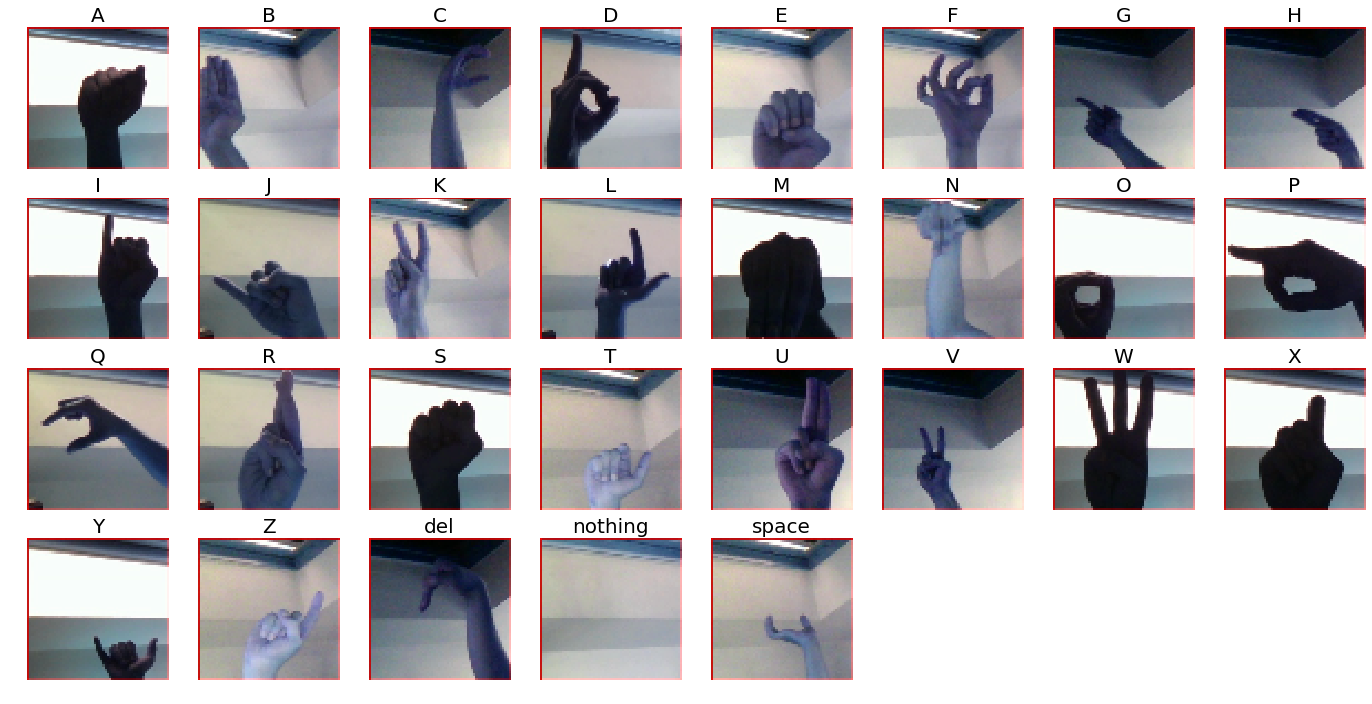

In [7]:
y_test_in = y_test.argsort()
y_test = y_test[y_test_in]
X_test = X_test[y_test_in]

print("Testing images: ")
print_images(image_list = X_test)

The testing images look rather similar to the training images - this is because they have both been taken from the same dataset. Therefore, we can already expect that a model that does well with the training images will also do well with these testing images.

Do the evaluation images look similar to these? Let us have a look.

Evaluation images: 


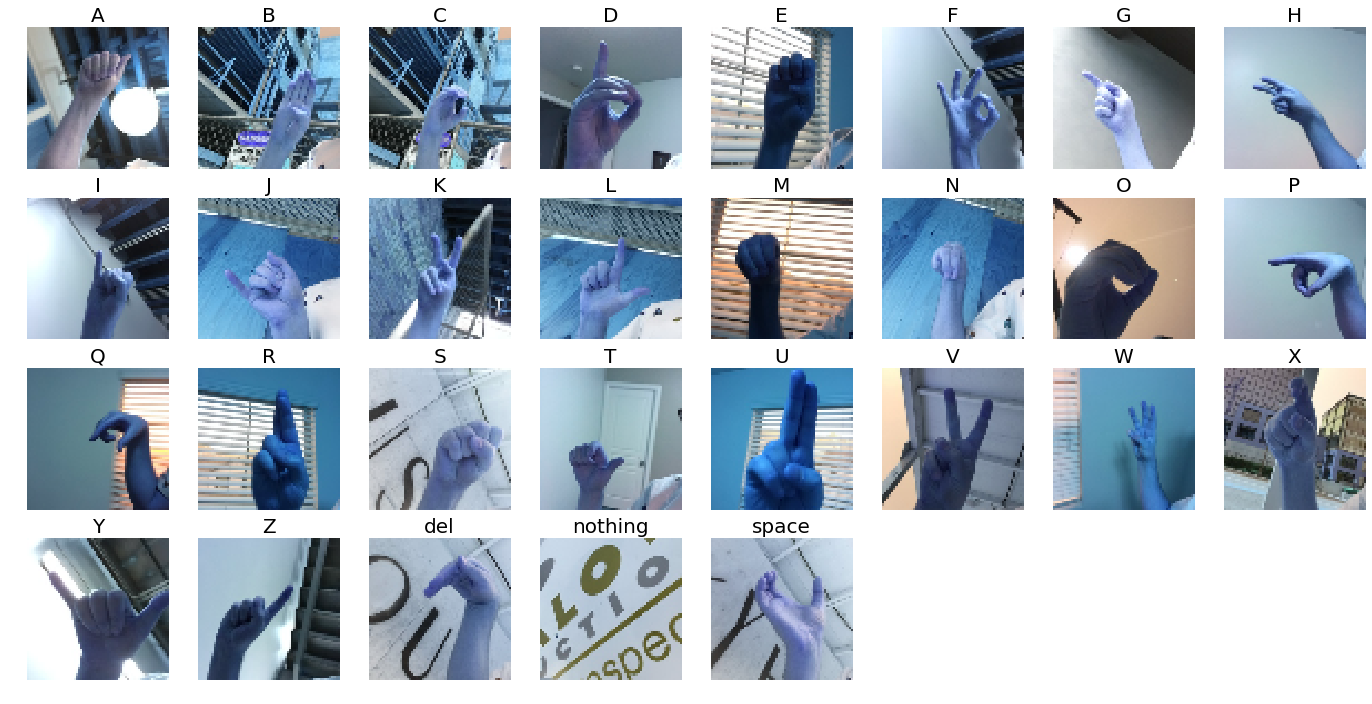

In [8]:
print("Evaluation images: ")
print_images(image_list = X_eval)

We see that the evaluation images do not, in fact, look at all similar to the training images. They have different hues and vastly different backgrounds. Indeed they are a much better embodiment of 'real-world data'. Therefore these will make a good test for our model's performance on 'real-world' ASL images.

**Note**: I did not use any sort on the evalutation arrays before printing. This is because the evaluation arrays did not go through a `train-test-split`, and therefore their sorting was never disturbed.

# 4. Preprocessing: One-hot enconding the data

I briefly covered label encoding earlier, where each letter of the labels is associated with a number:

`A` is encoded as `0`
`B` is encoded as `1`
`C` is encoded as `2`
`D` is encoded as `3`
 ...
 `nothing` is encoded as `28`
 
So, currently, our labels for each of the letters are encoded as categorical integers, where `'A', 'B' and 'C'` are encoded as `0, 1, and 2`, respectively. However, `keras` models do not accept labels in this format, and we must first one-hot encode the labels before supplying them to a `keras` model.

This conversion will turn the one-dimensional array of labels into a two-dimensional array. Each row in the two-dimensional array of one-hot encoded labels corresponds to a different label. The row has a `1` in the column that corresponds to the correct label, and 0 elsewhere.

For instance,

*    `0` is encoded as `[1, 0, 0]`,
*    `1` is encoded as `[0, 1, 0]`, and
*    `2` is encoded as `[0, 0, 1]`.

The image below summarizes these concepts:

<img src="https://i.imgur.com/CtSIsMP.jpg" alt='Label encoding and One-hot encoding' style="width: 800px;"/>

One-hot encoding is easy to do using `keras`:

In [9]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_eval = keras.utils.to_categorical(y_eval)

Now we can have a look at one of the labels to see if it is indeed one-hot encoded:

In [10]:
print(y_train[0])
print(len(y_train[0]))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
29


The length is 29, to make room for the 29 labels `A` to `nothing` in our data.

# 5. Preprocessing - Normalize RGB values

There are three components for each image - one component each for the Red, Green, and Blue (RGB) channels. The component values are stored as integer numbers in the range 0 to 255, the range that a single 8-bit byte can offer. 

If, however, we divide by 255 the range can be described with a 0.0-1.0 where 0.0 means 0 (0x00 in hex) and 1.0 means 255 (0xFF in hex). Normalization will help us remove distortions caused by lights and shadows in an image. This is a good idea for our dataset as we have seen that our images have a lot of different light and shadow areas.

The following image is an example of what this normalization of RGB values does:

<img src="http://aishack.in/static/img/tut/normalized-rgb.jpg" alt="RGB vs Normalized RGB" style="width:300px">

A more detailed explanation can be found [here](http://aishack.in/tutorials/normalized-rgb/).

In [11]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

Having loaded, understood and pre-processed our data, it is finally time to turn to the model.

# 5. Define and run the model

I will define a deep learning model, a convolutional neural network (CNN) to classify the data. CNNs are a specific kind of artificial neural network that is very effective for image classification because they are able to take into account the spatial coherence of the image, i.e., that pixels close to each other are often related. This network accepts an image of an American Sign Language letter as input. The output layer returns the network's predicted probabilities that the image belongs in each category.

We'll add the following layers:

*     MaxPooling. This passes a (4, 4) moving window over the image and downscales the image by outputting the maximum value within the window.
*     Dropout. This prevents the model from overfitting, i.e. perfectly remembering each image, by randomly setting a percentage of the input units to 0 at each update during training.
*     Conv2D. Add further convolutional layers since deeper models, i.e. models with more convolutional layers, are better able to learn features from images.
*     Flatten. As its name suggests, this flattens the output from the convolutional part of the CNN into a one-dimensional feature vector which can be passed into the following fully connected layers.
*     Dense. Fully connected layer where every input is connected to every output.

<img src="https://i.imgur.com/6Crxeo5.png" alt="Fully connected layer vs Convolutional Layer" >

To take a look at how it all stacks up, we'll print the model summary. Notice that our model has a whopping `1,660,253` paramaters. These are the different weights that the model learns through training and what are used to generate predictions on a new image.

In [12]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.layers import Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu', 
                 input_shape = (64, 64, 3)))
model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (4, 4)))
model.add(Dropout(0.5))
model.add(Conv2D(filters = 128 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (4, 4)))
model.add(Dropout(0.5))
model.add(Conv2D(filters = 256 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(29, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        4864      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
conv2d_4 (Conv2D)    

After having defined a neural network in `keras`, the next step is to compile it.

In [13]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

We're ready to fit it to the training data. The values `acc` will give us the accuracy of the model after each epoch. I will run the model for a total of 5 epochs. Despite our high number of parameters and large dataset, the model runs rather quickly as `keras` is able to engage the GPU in its functioning.

In [14]:
hist = model.fit(X_train, y_train, epochs = 5, batch_size = 64)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
78300/78300 [==============================] - 38s 486us/step - loss: 1.2149 - acc: 0.6351
Epoch 2/5
78300/78300 [==============================] - 32s 404us/step - loss: 0.1975 - acc: 0.9364
Epoch 3/5
78300/78300 [==============================] - 32s 410us/step - loss: 0.1304 - acc: 0.9622
Epoch 4/5
78300/78300 [==============================] - 32s 404us/step - loss: 0.1123 - acc: 0.9700
Epoch 5/5
78300/78300 [==============================] - 32s 409us/step - loss: 0.1108 - acc: 0.9727


# 7. Test the model

We can now test the model on our testing and evaluation images. We are looking to note the difference between how the model performs with the testing images vs the evaluation or real-world images.

In [15]:
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 99.816 %
Accuracy for evaluation images: 42.529 %


We see that our model does rather well with the testing images which came from the same batch as the training data. this is unsurprising given that our model performed well with the training data. On the evaluation images however, our model does rather poorly with less than 50% accuracy. This tells us that we need to include more varied data in our analysis to get better results with real-world images. A great way to visualize the successes and errors of our model is to plot confusion matrices, which I will do next.

# 8. Confusion Matrices

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. Each row of the matrix represents the instances in an actual class while each column represents the instances in an predicted class (or vice versa). The name stems from the fact that it makes it easy to see if the system is confusing two classes (i.e. commonly mislabeling one as another).

I will plot confusion matrices for both the testing and evaluation data. The function below does exactly that. The code `y = np.argmax(y, axis = 1)` converts the 2D array y into a 1D array with number labels for each image. I do this for both the true and the predicted values. Additionally, plotting the confusion matrix with a `cmap` automatically fills it with a colour gradient showing how many of the values were correctly predicted. The `for` loop at the end of the function fills each cell of the matrix with the number of predictions that correspond to that cell.

In [16]:
#Helper function to plot confusion matrix
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

With our function now ready we can plot the first confusion matrix. This will be the matrix for the testing data, which gave a high accuracy. We expect to find the diagonal elements to have large values with some values distributed in non-diagonal elements. Note that our the matrix is not normalized, and the total number of testing images per label were 300.

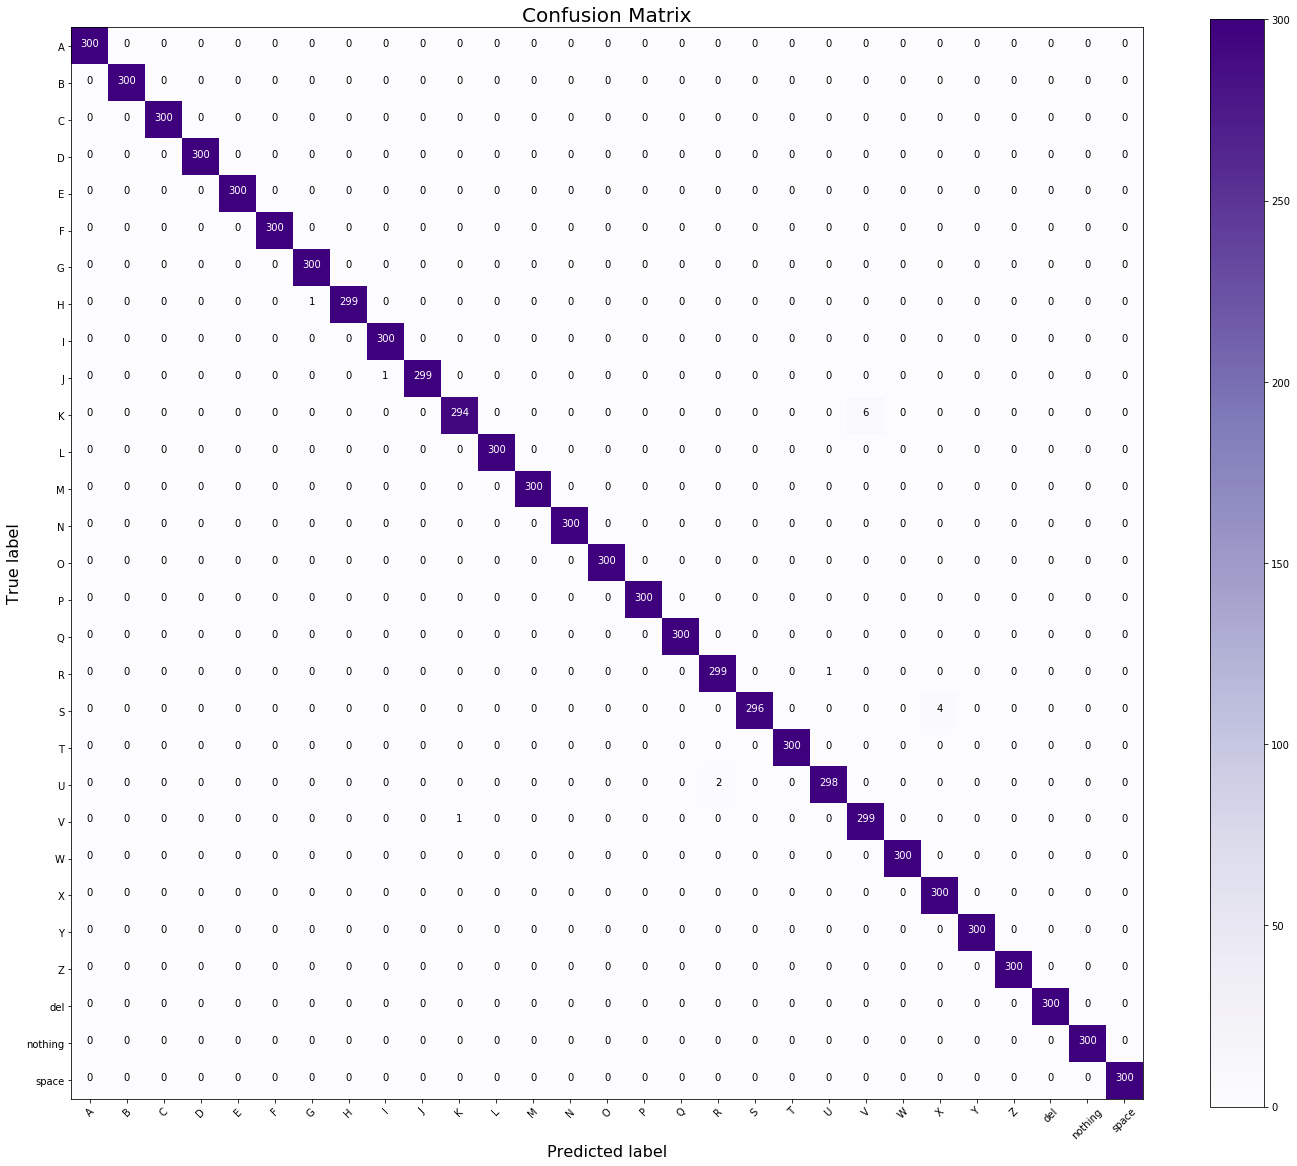

In [17]:
from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

Note that most of diagonal elements have values 300, and the non-diagonal elements have values 0, indicating that the model labeled most of our data correctly.

Next I will plot the confusion matrix for the evaluation images. Once again, the matrix is not normalized so it is important to note that for every label we had 30 evaluation images.

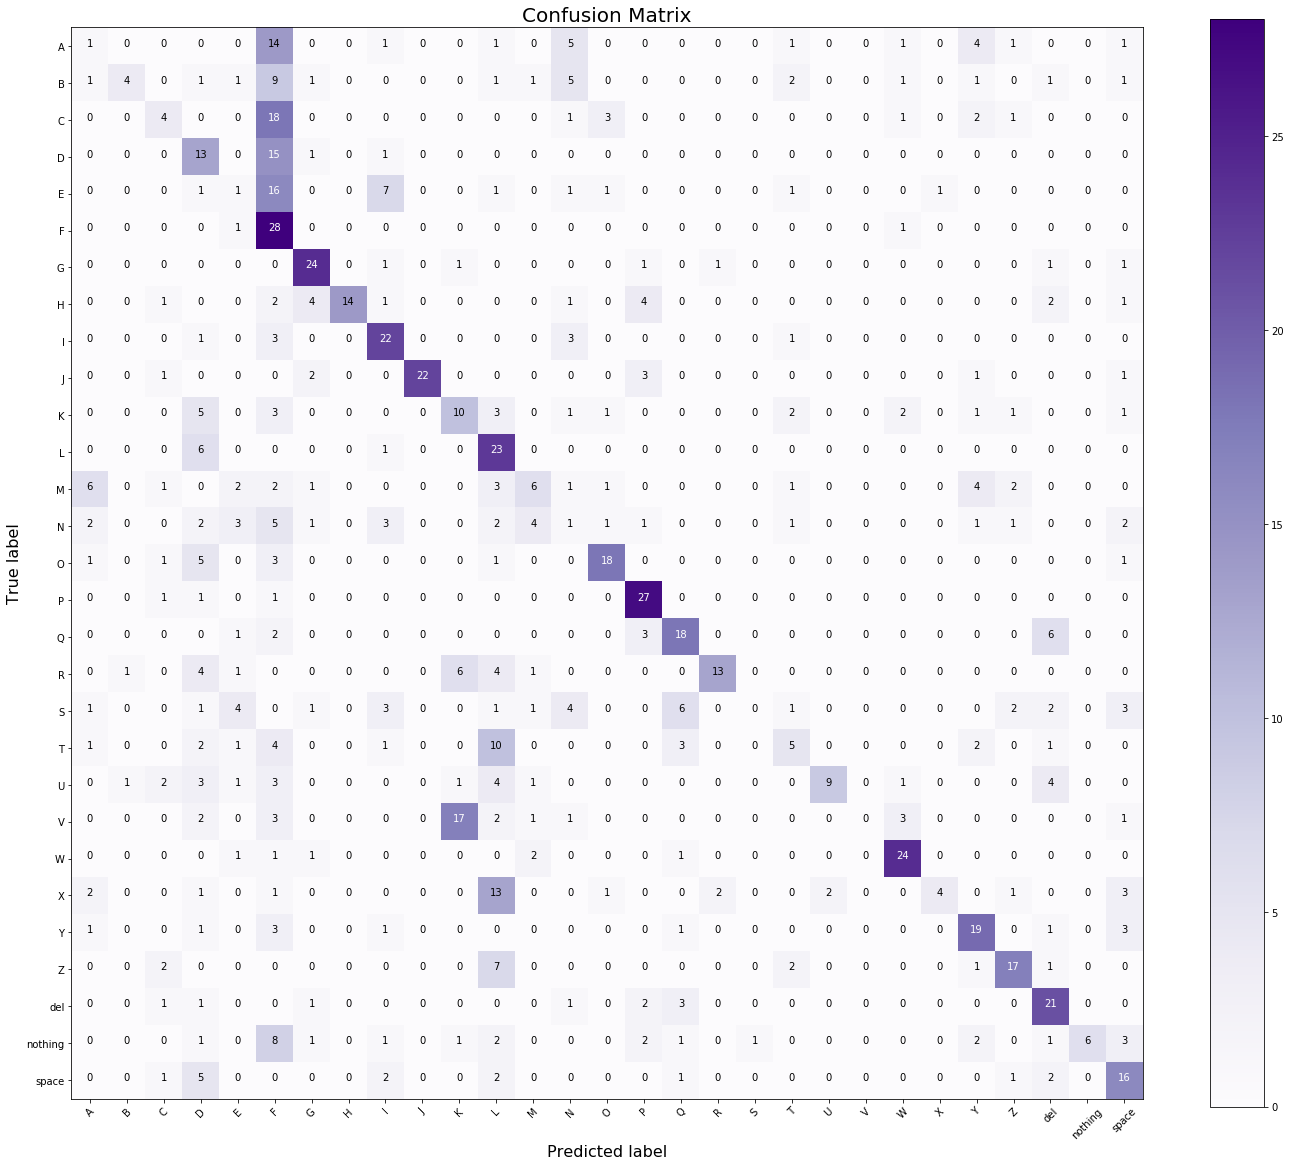

In [18]:
y_eval_pred = model.predict(X_eval, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)

This is a much more interesting confusion matrix, with a lot of information. Our model performed best with images of P and F. We also see that the model got none of the images for A correct, and that it mistakenly labeled a signficant number of Vs as Ks. Studying this confusion matrix gives us a detailed and interesting view into the workings of our model on the evaluation images.

In [19]:
model.save('my_model.h5') 

In [34]:
# Modify 'test1.jpg' and 'test2.jpg' to the images you want to predict on

from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# dimensions of our images
img_width, img_height = 64, 64

# load the model we saved
model = load_model('my_model.h5')
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# predicting images
img = image.load_img('../input/asl-test/images.png', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict_classes(images, batch_size=10)
print(uniq_labels[classes[0]])

# # predicting multiple images at once
# img = image.load_img('test2.jpg', target_size=(img_width, img_height))
# y = image.img_to_array(img)
# y = np.expand_dims(y, axis=0)

# # pass the list of multiple images np.vstack()
# images = np.vstack([x, y])
# classes = model.predict_classes(images, batch_size=10)

# # print the classes, the images belong to
# print classes
# print classes[0]
# print classes[0][0]

F


In [ ]:
for i in range(uniq_labels):
    print()

In [20]:
image = cv2.imread('../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/C/C1000.jpg',cv2.IMREAD_UNCHANGED)
im4 = np.resize(image, (64,64,3))
im5 = np.expand_dims(im4,axis=0)
data = np.asarray(im5, dtype="int32")
pred_probab = model.predict(data)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  6,  9, 12, 21,
        25, 25, 50, 50, 62]),
 array([ 4,  5, 